In [1]:
%run notebook_config

# Gaussian processes

`caustic` enables the use of [Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/) for modeling correlated noise. The basic idea behind GPs is to extend the covariance matrix of the multivariate gaussian likelihood we've used in the previous tutorial and model the covariance matrix terms by means of a kernel function
which depends on the difference between any two time points at which we measured the flux. That is
   
$$\kappa(t)=\kappa \,(|t-t'|)$$

Such a kernel is said to be stationary because it defines a stationary gaussian process. The covariance matrix terms are then

$$
\boldsymbol{\Sigma}_{i, j}=\kappa\left(|t_{i}- t_{j}|\right)+\sigma_{i}^{2} \delta_{i, j}
$$

where $\sigma_i$ are the "error bars" provided by photometry reduction pipelines. Because the covariance matrix is no longer diagonal, and the likelihood function involves computing its inverse and the determinant, naive implementations are extremely costly because the computation of a matrix inverse scales like $\mathcal{O}(N^3)$. Fortunately, the recent
package [celerité](https://celerite.readthedocs.io/en/stable/) enables computation of the gaussian process likelihood in linear time. It does this by restricting the application of GPs to one-dimensional data and a special class of kernel functions which result enable efficient computation of the inverse and the determinant of the covariance matrix. The restricted class of kernels is still sufficient for use in microlensing data. 

For more info on celerité, see the package documentation and the associated [paper](https://ui.adsabs.harvard.edu/abs/2017AJ....154..220F/abstract).

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


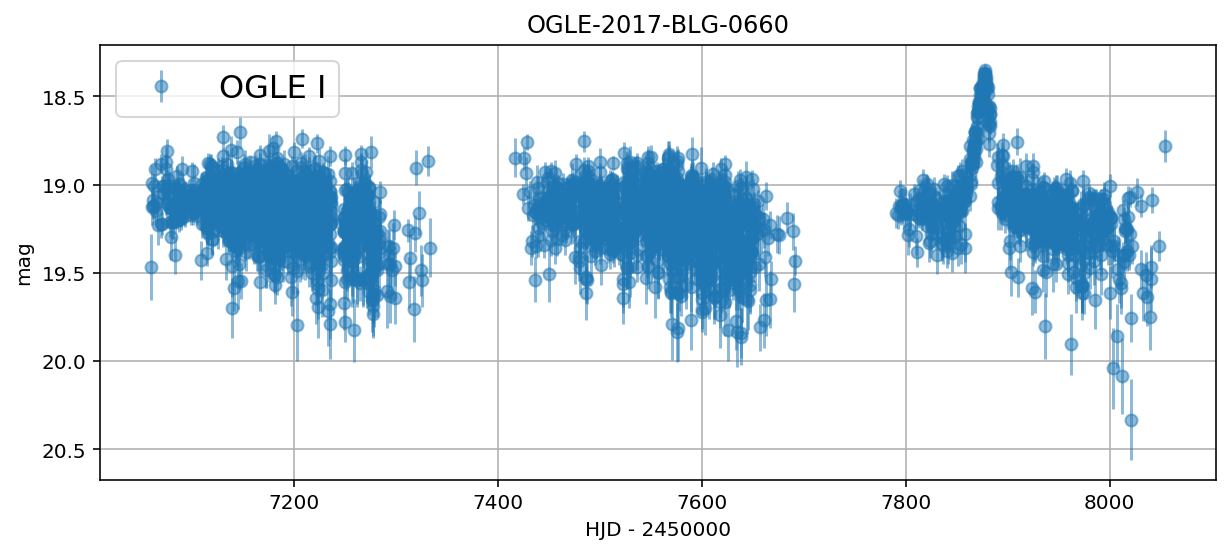

In [2]:
import numpy as np
from matplotlib import pyplot as plt

import pymc3 as pm
import theano.tensor as T

import caustic as ca
import exoplanet as xo

np.random.seed(42)

event = ca.data.OGLEData("../../data/OGLE-2017-BLG-0660")

fig, ax = plt.subplots(figsize=(10, 4))
event.plot(ax)

Let's first fit a model with a diagonal covariance matrix.

In [3]:
# Initialize a SingleLensModel object
model = ca.models.SingleLensModel(event)

In [4]:
with model:
    n_bands = len(event.light_curves)

    # Initialize linear parameters
    testval_ln_DeltaF = T.log(
        ca.utils.estimate_peak_flux(event) - ca.utils.estimate_baseline_flux(event)
    )  # helper functions
    ln_DeltaF = pm.Normal("ln_DeltaF", mu=4.0, sd=4, testval=testval_ln_DeltaF[0])
    DeltaF = T.exp(ln_DeltaF)

    ln_Fbase = pm.Normal(
        "ln_Fbase", mu=2, sd=4, testval=T.log(ca.utils.estimate_baseline_flux(event)[0])
    )
    Fbase = T.exp(ln_Fbase)

    # Initialize nonlinear parameters
    t0 = pm.Uniform(
        "t0", model.t_min, 2 * model.t_max, testval=ca.utils.estimate_t0(event)
    )
    ln_tE = pm.Normal("ln_tE", mu=3.0, sd=6, testval=2.0)

    tE = pm.Deterministic("tE", T.exp(ln_tE))

    u0 = pm.Exponential("u0", 0.5, testval=0.1)

    # Compute the source magnitude and blending fraction
    m_source, g = ca.utils.compute_source_mag_and_blend_fraction(
        event, DeltaF, Fbase, u0
    )
    pm.Deterministic("m_source", m_source)
    pm.Deterministic("g", g)

    # Compute the trajectory of the les
    trajectory = ca.trajectory.Trajectory(event, t0, u0, tE)
    u = trajectory.compute_trajectory(model.t)

    # Compute the magnification
    mag = model.compute_magnification(u, u0)

    # Compute the mean model
    mean = DeltaF * mag + Fbase

    # We allow for rescaling of the error bars by a constant factor
    ln_c = pm.Exponential("ln_c", 0.5, testval=0.8 * T.ones(n_bands))

    # Diagonal terms of the covariance matrix
    var_F = (T.exp(ln_c) * model.sigF) ** 2

    # Compute the Gaussian log_likelihood, add it as a potential term to the model
    ll = model.compute_log_likelihood(model.F - mean, var_F)
    pm.Potential("log_likelihood", ll)

In [5]:
with model:
    # Print initial logps
    print("Model test point:\n", model.check_test_point())

    # Run sampling
    trace = pm.sample(tune=500, draws=1000, cores=4, step=xo.get_dense_nuts_step())

Model test point:
 ln_DeltaF       -2.38
ln_Fbase        -2.32
t0_interval__   -2.50
ln_tE           -2.72
u0_log__        -3.05
ln_c_log__      -1.32
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ln_c, u0, ln_tE, t0, ln_Fbase, ln_DeltaF]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:26<00:00, 225.59draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9201355963641006, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890251066852598, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [6]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ln_DeltaF,2.578556,0.021996,0.000492,2.536055,2.621639,2310.502730,1.000701
ln_Fbase,2.624532,0.001819,0.000035,2.620776,2.627997,2978.501309,0.999719
ln_tE,1.920702,0.538526,0.021780,0.720911,2.670468,564.057495,1.000018
t0,7876.709482,0.224309,0.004561,7876.277796,7877.134625,2695.185392,1.000201
tE,7.741393,3.501642,0.124921,1.727198,13.637477,764.824797,0.999912
u0,1.907487,1.631216,0.070757,0.378127,5.642869,478.793773,0.999845
m_source,16.813957,2.129674,0.087196,12.276231,19.714933,548.128065,1.000031
g,-0.658311,0.381365,0.011075,-0.999948,0.107813,1313.654378,0.999660
ln_c__0,0.594759,0.010809,0.000203,0.574805,0.617066,3306.563451,1.000457


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


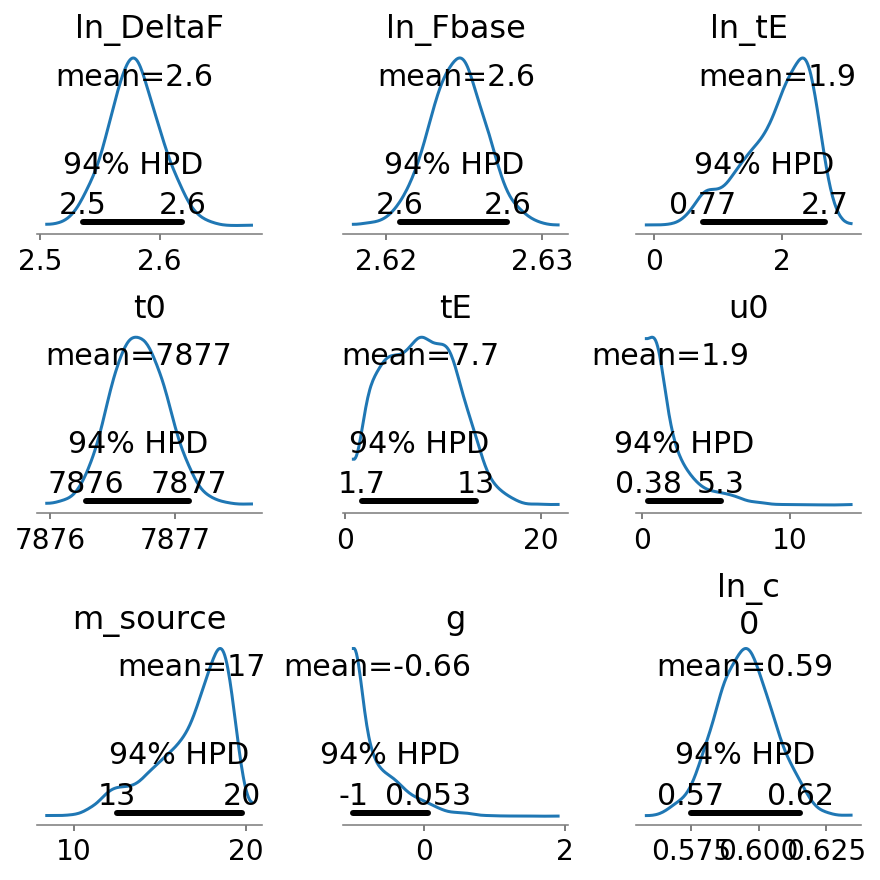

In [7]:
pm.plot_posterior(trace, figsize=(6, 6));

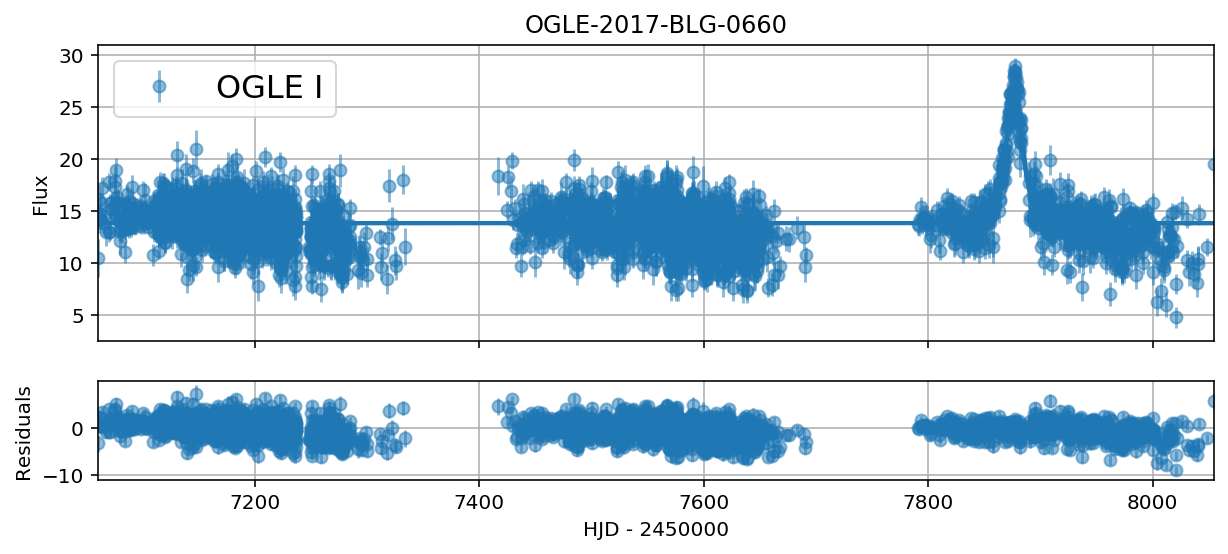

In [8]:
with model:
    # Create dense grid
    t_dense = np.tile(np.linspace(model.t_min, model.t_max, 2000), (n_bands, 1))
    t_dense_tensor = T.as_tensor_variable(t_dense)

    # Compute the trajectory of the lens
    trajectory = ca.trajectory.Trajectory(event, t0, u0, tE)
    u_dense = trajectory.compute_trajectory(t_dense_tensor)

    # Compute the magnification
    mag_dense = model.compute_magnification(u_dense, u0)

    # Compute the mean model
    mean_dense = DeltaF * mag_dense + Fbase

# Plot model
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(10, 4), sharex=True
)

samples = list(xo.get_samples_from_trace(trace, size=50))

with model:
    ca.utils.plot_model_and_residuals(ax, event, samples, t_dense_tensor, mean_dense)

We can see clear correlations in the residuals which aren't accounted for by the model. To expand the model we include a GP.

In [9]:
# Initialize a SingleLensModel object
model_gp = ca.models.SingleLensModel(event)

with model_gp:
    n_bands = len(event.light_curves)

    # Initialize linear parameters
    testval_ln_DeltaF = T.log(
        ca.utils.estimate_peak_flux(event) - ca.utils.estimate_baseline_flux(event)
    )  # helper functions
    ln_DeltaF = pm.Normal("ln_DeltaF", mu=4.0, sd=4, testval=testval_ln_DeltaF[0])
    DeltaF = T.exp(ln_DeltaF)

    ln_Fbase = pm.Normal(
        "ln_Fbase", mu=2, sd=4, testval=T.log(ca.utils.estimate_baseline_flux(event)[0])
    )
    Fbase = T.exp(ln_Fbase)

    # Initialize nonlinear parameters
    t0 = pm.Uniform(
        "t0", model_gp.t_min, 2 * model_gp.t_max, testval=ca.utils.estimate_t0(event)
    )
    ln_tE = pm.Normal("ln_tE", mu=3.0, sd=6, testval=2.0)

    tE = pm.Deterministic("tE", T.exp(ln_tE))

    u0 = pm.Exponential("u0", 0.5, testval=0.1)

    # Compute the source magnitude and blending fraction
    m_source, g = ca.utils.compute_source_mag_and_blend_fraction(
        event, DeltaF, Fbase, u0
    )
    pm.Deterministic("m_source", m_source)
    pm.Deterministic("g", g)

    # Compute the trajectory of the les
    trajectory = ca.trajectory.Trajectory(event, t0, u0, tE)
    u = trajectory.compute_trajectory(model_gp.t)

    # Compute the magnification
    mag = model_gp.compute_magnification(u, u0)

    # Compute the mean model
    mean = DeltaF * mag + Fbase

    # We allow for rescaling of the error bars by a constant factor
    ln_c = pm.Exponential("ln_c", 0.5, testval=0.8 * T.ones(n_bands))

    # Diagonal terms of the covariance matrix
    varF = (T.exp(ln_c) * model_gp.sigF) ** 2

We'll use the version of `celerite` implemented in the `exoplanet` code because it naturaly interfaces with `PyMC3` and provides gradient of the log likelihood with respect to the GP hyperparameters which is what we need for HMC to work. For more details check out the [exoplanet docs](https://exoplanet.dfm.io/en/latest/tutorials/gp/). We'll use the `exoplanet.gp.terms.Matern32` because it is a sensible default. This kernel is defined by two parameters, the characteristic lengthscale $\rho$ (in our case $\rho$ has dimensions of time since we're dealing with time series data), and $\sigma$ which controls the spread in the dependent variable (the flux). We have to be caref about choosing priors for the lengthscale parameter because GPs are somewhat prone to overfitting. Following the suggestions in this [Stan case study](https://betanalpha.github.io/assets/case_studies/gp_part1/part1.html), we opt to use an Inverse Gamma prior for $\rho$ which assigns 1\% probability to timescales less than the median separation between consecutive data points and 1\% probability to lengthscales larger than the entire duration of the time series. This is a sensible prior because it prevents the model from converging to timescales for which there is justification in the data. To compute the parameters of the Inverse Gamma distribution which satisfy the above requirements, we use the function `ca.compute_invgama_params`.


In [10]:
with model_gp:
    # Compute parameters for the prior
    invgamma_a, invgamma_b = ca.compute_invgamma_params(event)

    # Initialize the GP parameters for the Matern32 kernel
    ln_sigma_gp = pm.Normal("ln_sigma_gp", mu=0, sd=4.0, testval=0.5)
    rho_gp = pm.InverseGamma("rho_gp", invgamma_a, invgamma_b, testval=2.0)

    # List for storing xo.gp.GP objects
    gp_list = []

    kernel = xo.gp.terms.Matern32Term(log_sigma=ln_sigma_gp, rho=rho_gp)
    gp_list.append(xo.gp.GP(kernel, model_gp.t[0], varF[0], J=2))

    # Compute the Gaussian log_likelihood, add it as a potential term to the model_gp
    ll = model_gp.compute_log_likelihood(model_gp.F - mean, varF, gp_list)
    pm.Potential("log_likelihood", ll)

/Users/fb90/anaconda3/envs/pymc3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [11]:
with model_gp:
    # Print initial logps
    print("Model check point:\n", model_gp.check_test_point())

    # Run sampling
    trace_gp = pm.sample(
        tune=1000, draws=3000, cores=4, step=xo.get_dense_nuts_step(target_accept=0.9)
    )

Model check point:
 ln_DeltaF       -2.38
ln_Fbase        -2.32
t0_interval__   -2.50
ln_tE           -2.72
u0_log__        -3.05
ln_c_log__      -1.32
ln_sigma_gp     -2.31
rho_gp_log__    -2.60
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho_gp, ln_sigma_gp, ln_c, u0, ln_tE, t0, ln_Fbase, ln_DeltaF]
Sampling 4 chains: 100%|██████████| 16000/16000 [02:41<00:00, 99.32draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [12]:
pm.summary(trace_gp)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ln_DeltaF,2.596037,0.076604,0.000676,2.448192,2.748630,12931.882282,0.999936
ln_Fbase,2.599058,0.014641,0.000156,2.570637,2.628046,10420.694035,1.000126
ln_tE,2.320309,0.805175,0.010919,0.606349,3.688944,5656.149300,1.000675
ln_sigma_gp,-0.059747,0.127658,0.001312,-0.296296,0.198108,9545.214912,0.999963
t0,7876.793643,0.406112,0.003496,7875.961153,7877.567340,13389.483789,1.000034
tE,14.621668,41.031100,0.905136,0.933111,34.034329,2023.228441,1.000955
u0,1.377078,1.638713,0.023809,0.002047,4.867991,4895.950599,1.000698
m_source,17.993090,2.469545,0.033676,12.541883,21.692456,5532.751621,1.000697
g,0.496768,6.996691,0.157464,-0.999973,3.747258,1942.521950,1.000933
ln_c__0,0.497593,0.011230,0.000088,0.475052,0.518866,15084.673958,0.999843


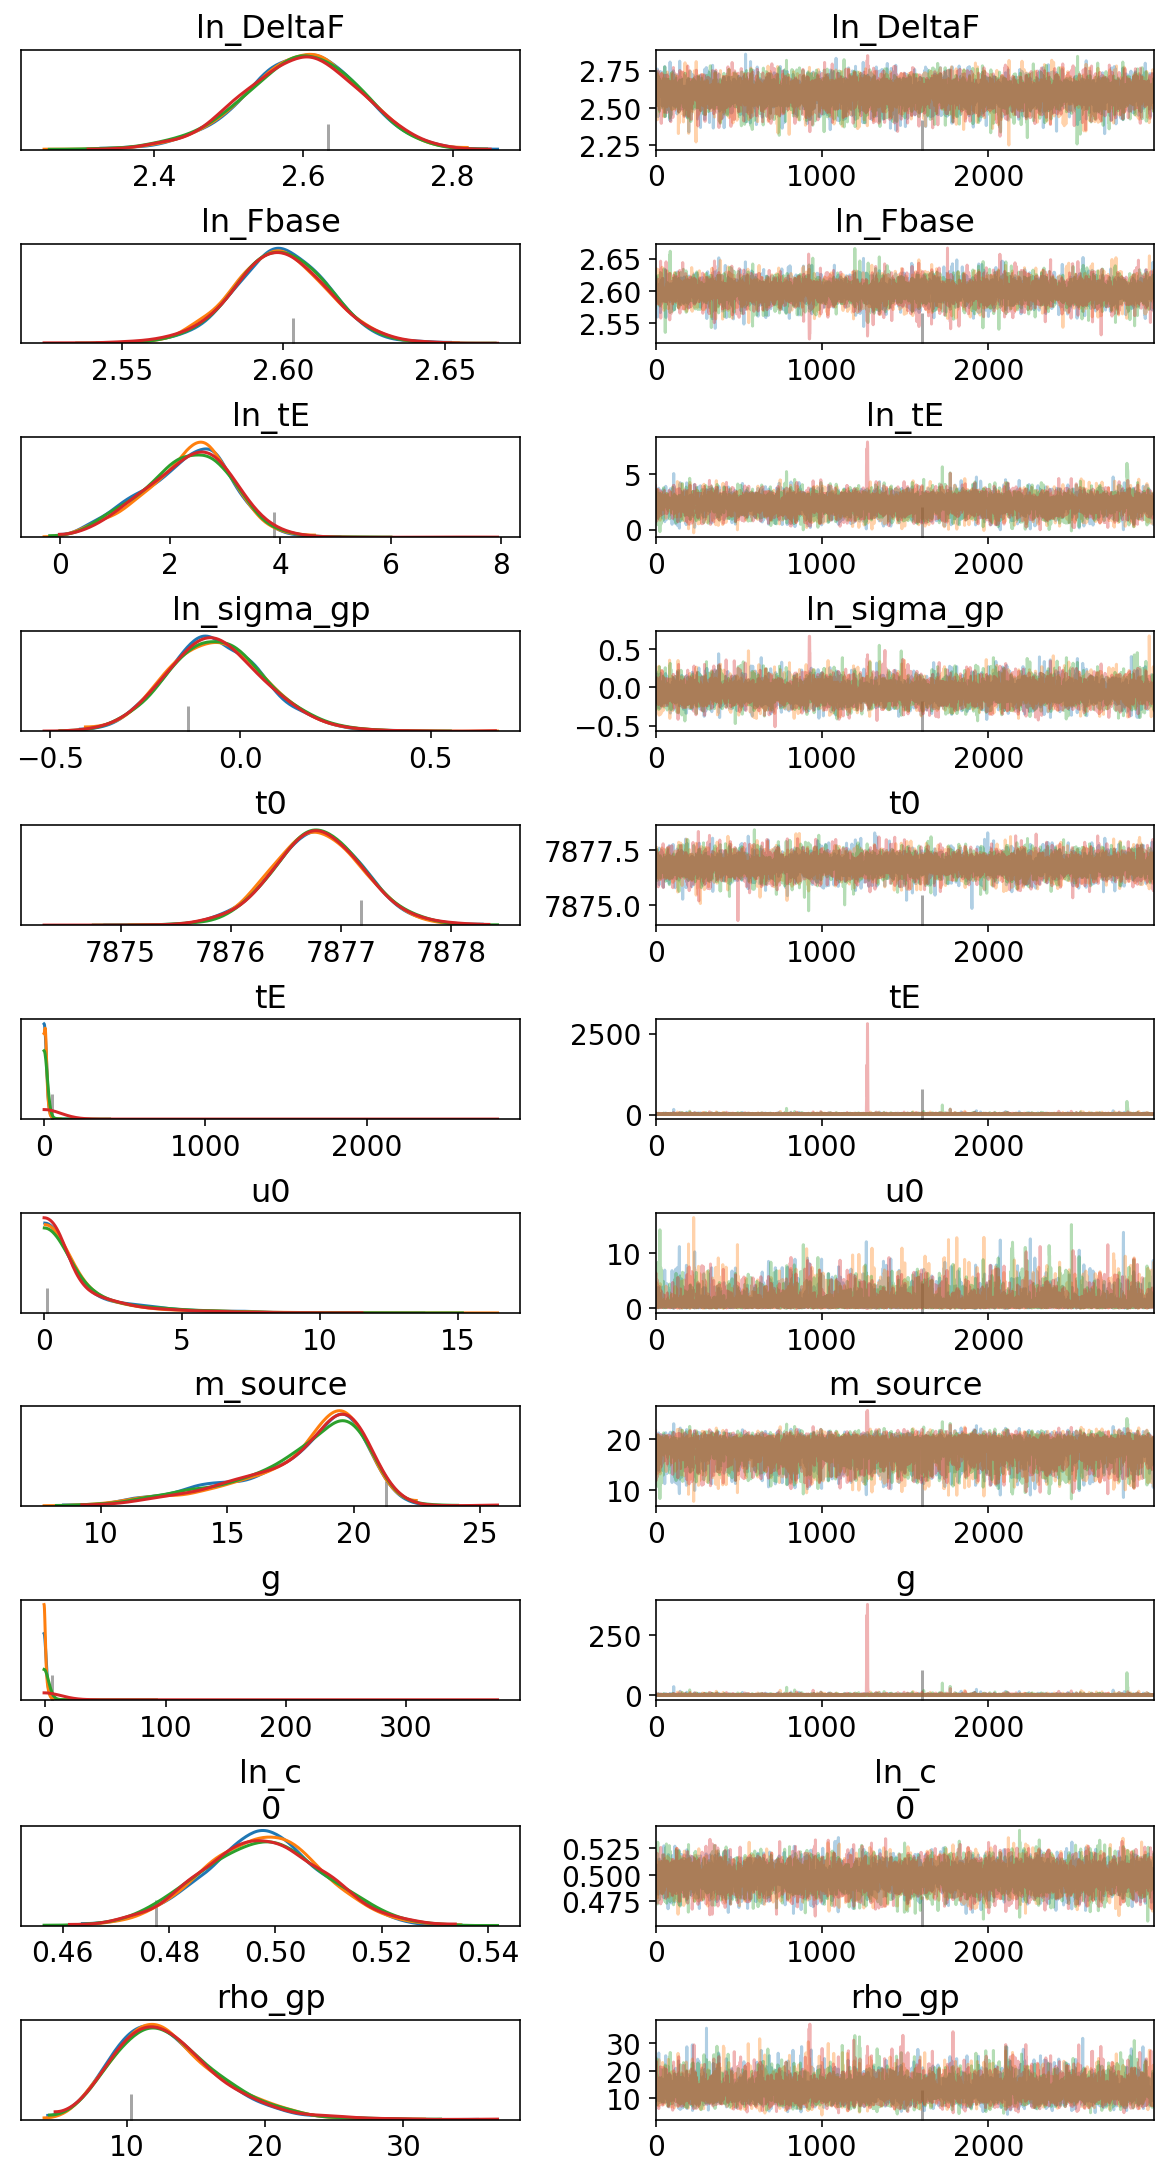

In [13]:
pm.traceplot(trace_gp, figsize=(8, 15));

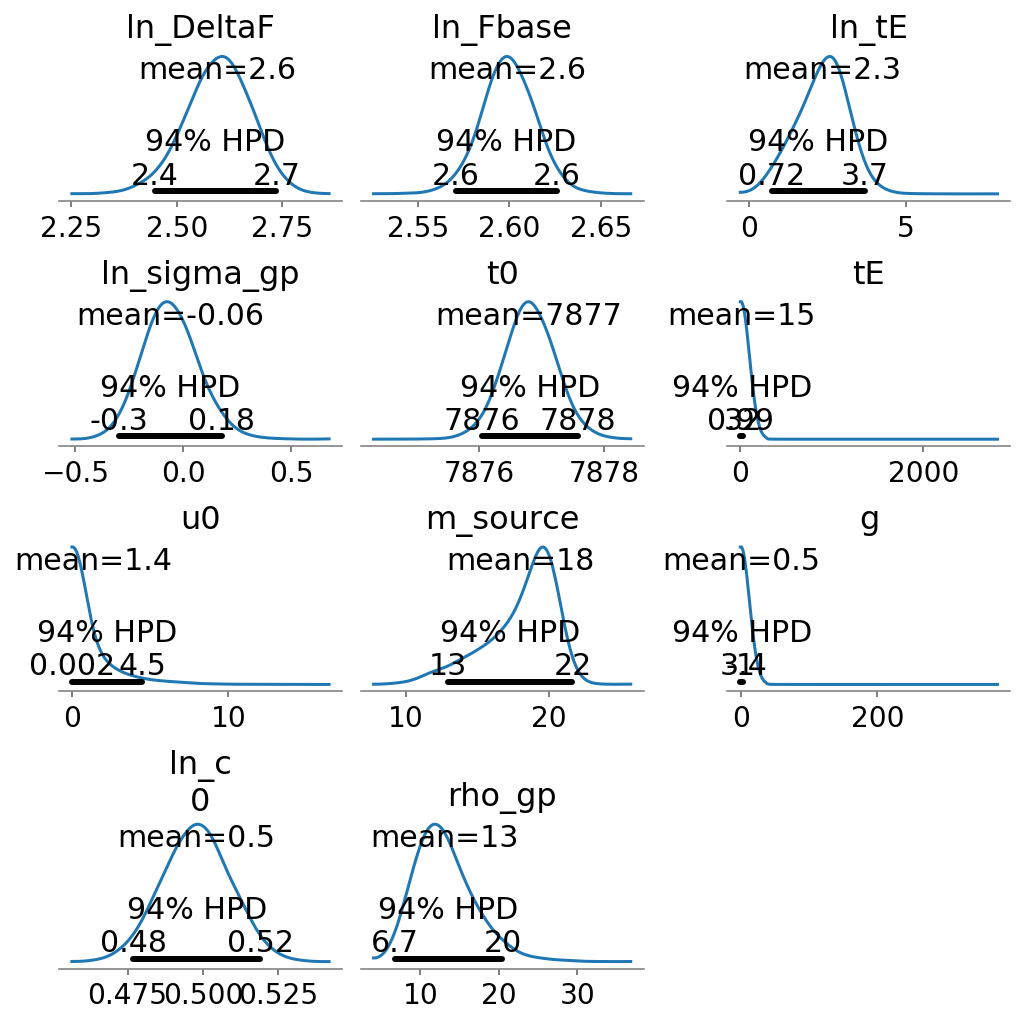

In [14]:
pm.plot_posterior(trace_gp, figsize=(7, 7));

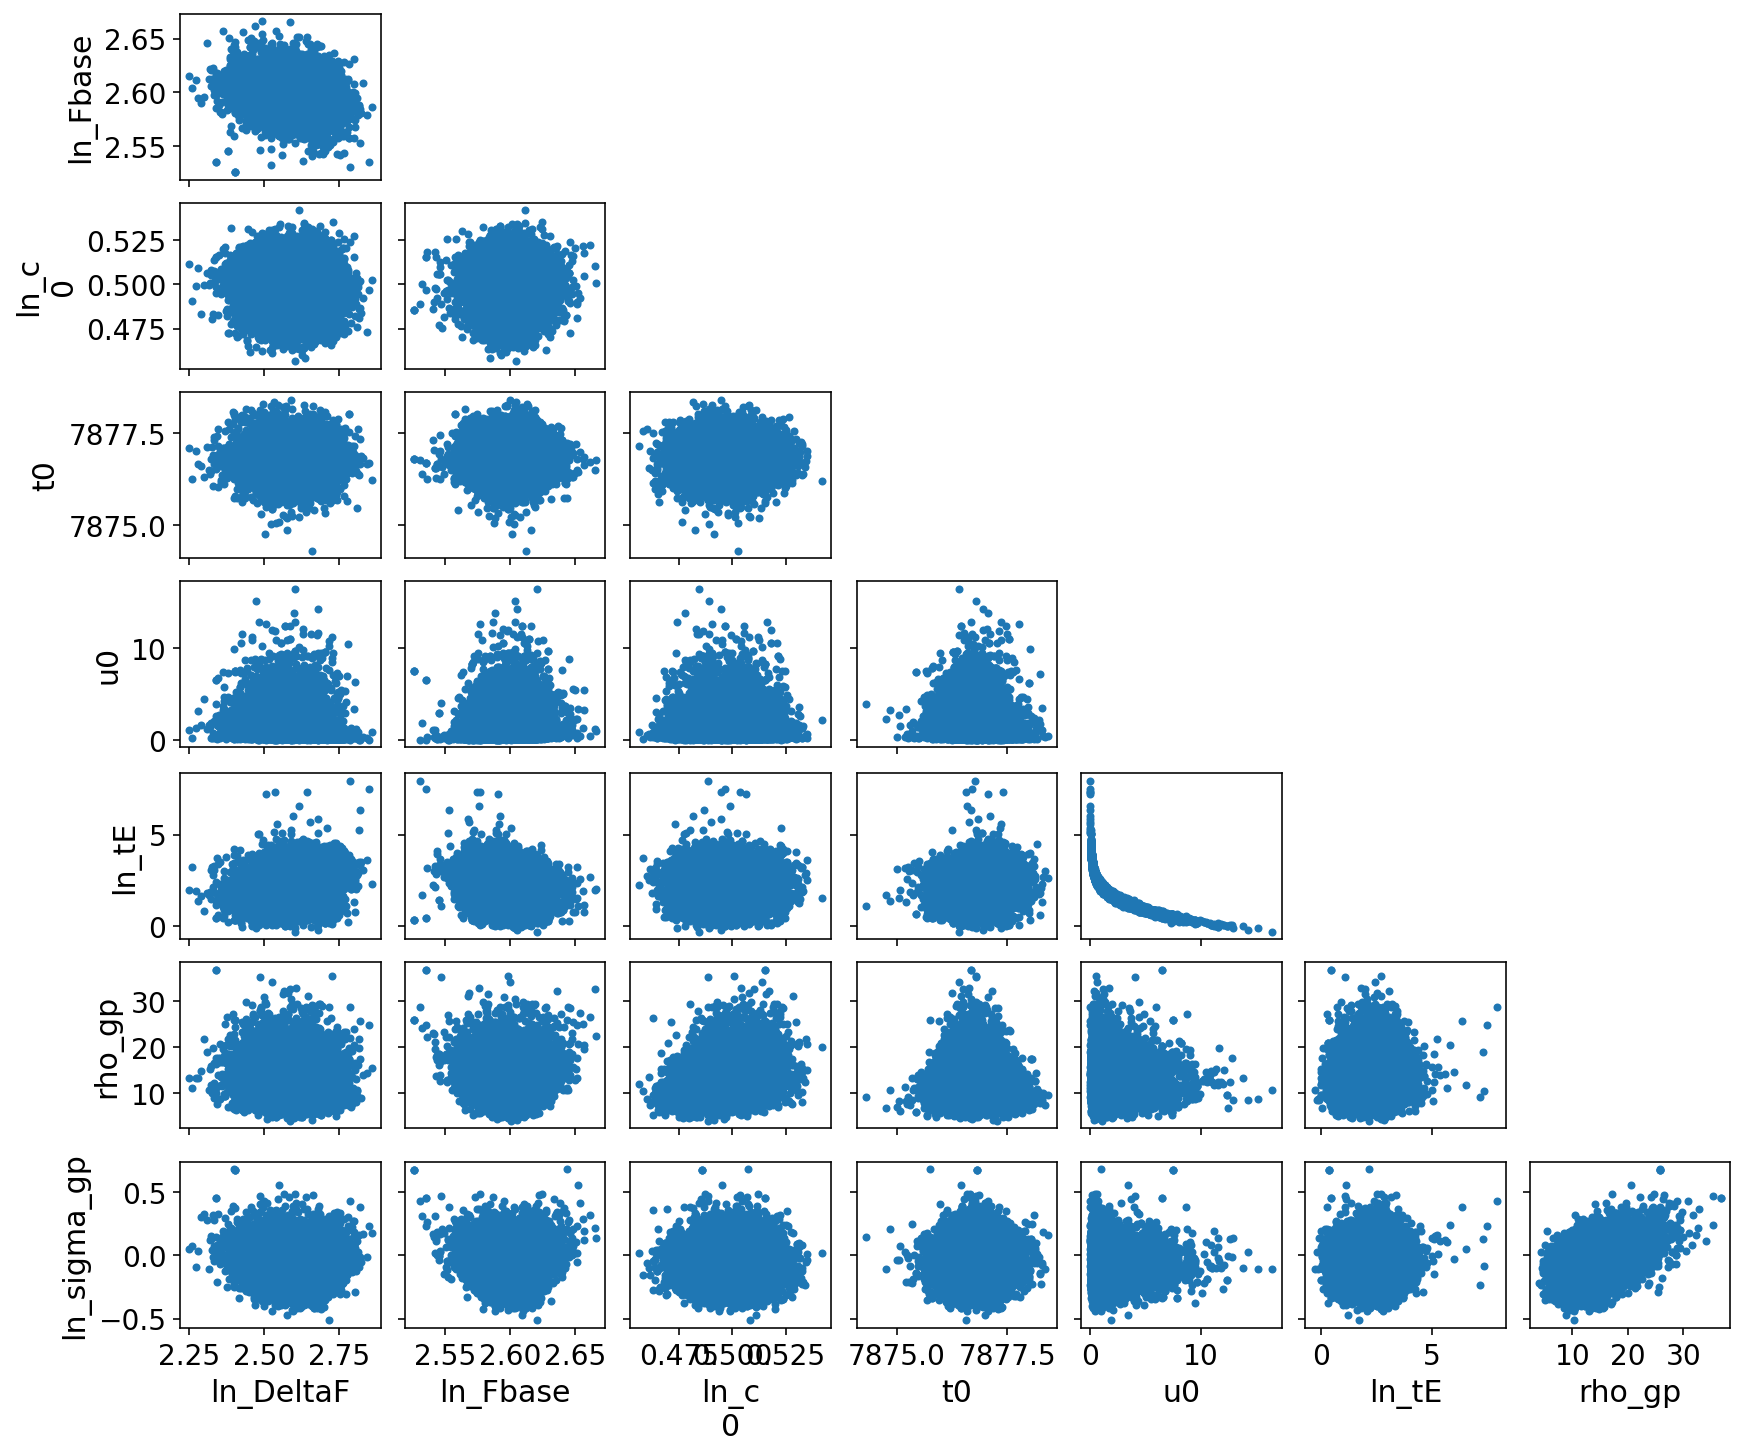

In [15]:
pm.pairplot(
    trace_gp,
    figsize=(12, 10),
    var_names=[
        "ln_DeltaF",
        "ln_Fbase",
        "ln_c",
        "t0",
        "u0",
        "ln_tE",
        "rho_gp",
        "ln_sigma_gp",
    ],
);

Let's plot the model

In [16]:
def plot_model_and_residuals(
    ax, data, samples, t_grid, prediction, gp_list=None, model=None, **kwargs
):
    model = pm.modelcontext(model)

    n_samples = len(samples)

    # Load data
    if model.is_standardized is True:
        tables = data.get_standardized_data()
    else:
        tables = data.get_standardized_data(rescale=False)

    # Evaluate model for each sample on a fine grid
    n_pts_dense = T.shape(t_grid)[1].eval()
    n_bands = len(data.light_curves)

    prediction_eval = np.zeros((n_samples, n_bands, n_pts_dense))

    # Evaluate predictions in model context
    if gp_list is None:
        for i, sample in enumerate(samples):
            prediction_eval[i] = xo.eval_in_model(prediction, sample)

    else:
        prediction_tensors = [gp_list[n].predict(t_grid[n]) for n in range(n_bands)]
        for i, sample in enumerate(samples):
            for n in range(n_bands):
                prediction_eval[i, n] = xo.eval_in_model(prediction_tensors[n], sample)

            # Add mean model to GP prediction
            prediction_eval[i] += xo.eval_in_model(prediction, sample)

    # Plot model predictions for each different samples from posterior on dense
    # grid
    for n in range(n_bands):  # iterate over bands
        for i in range(n_samples):
            ax[0].plot(
                t_grid[n].eval(),
                prediction_eval[i, n, :],
                color="C" + str(n),
                alpha=0.2,
                **kwargs,
            )

    # Compute median of the predictions
    median_predictions = np.zeros((n_bands, n_pts_dense))
    for n in range(n_bands):
        median_predictions[n] = np.percentile(prediction_eval[n], [16, 50, 84], axis=0)[
            1
        ]

    # Plot data
    data.plot_standardized_data(ax[0], rescale=model.is_standardized)
    ax[0].set_xlabel(None)
    ax[1].set_xlabel("HJD - 2450000")
    ax[1].set_ylabel("Residuals")
    ax[0].set_xlim(T.min(t_grid).eval(), T.max(t_grid).eval())

    # Compute residuals with respect to median model
    for n in range(n_bands):
        # Interpolate median predictions onto a grid of observed times
        median_pred_interp = np.interp(
            tables[n]["HJD"], t_grid[n].eval(), median_predictions[n]
        )

        residuals = tables[n]["flux"] - median_pred_interp

        ax[1].errorbar(
            tables[n]["HJD"],
            residuals,
            tables[n]["flux_err"],
            fmt="o",
            color="C" + str(n),
            alpha=0.5,
            **kwargs,
        )
        ax[1].grid(True)

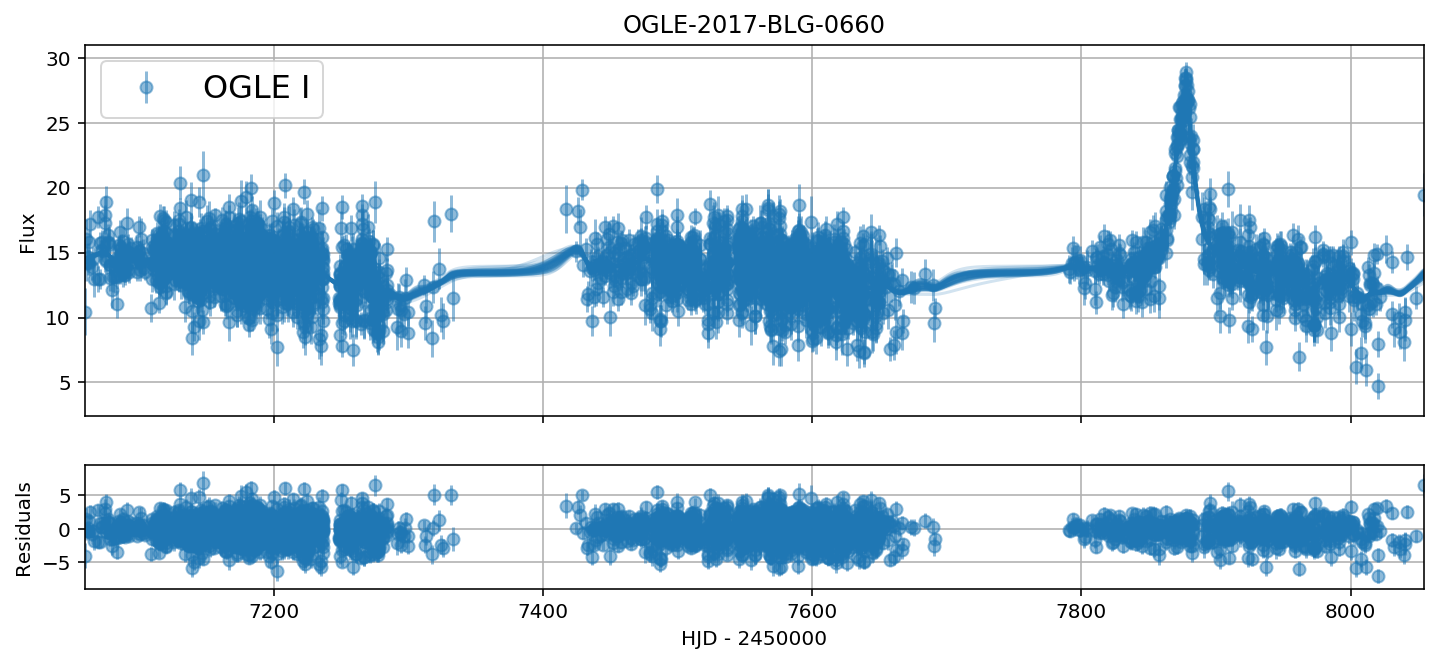

In [17]:
with model_gp:
    # Create dense grid
    t_dense = np.tile(np.linspace(model_gp.t_min, model_gp.t_max, 1000), (n_bands, 1))
    t_dense_tensor = T.as_tensor_variable(t_dense)

    # Compute the trajectory of the lens
    trajectory = ca.trajectory.Trajectory(event, t0, u0, tE)
    u_dense = trajectory.compute_trajectory(t_dense_tensor)

    # Compute the magnification
    mag_dense = model_gp.compute_magnification(u_dense, u0)

    # Compute the mean model
    mean_dense = DeltaF * mag_dense + Fbase

# Plot model
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(12, 5), sharex=True
)

samples = list(xo.get_samples_from_trace(trace_gp, size=50))

with model_gp:
    ca.utils.plot_model_and_residuals(
        ax, event, samples, t_dense_tensor, mean_dense, gp_list=gp_list
    )

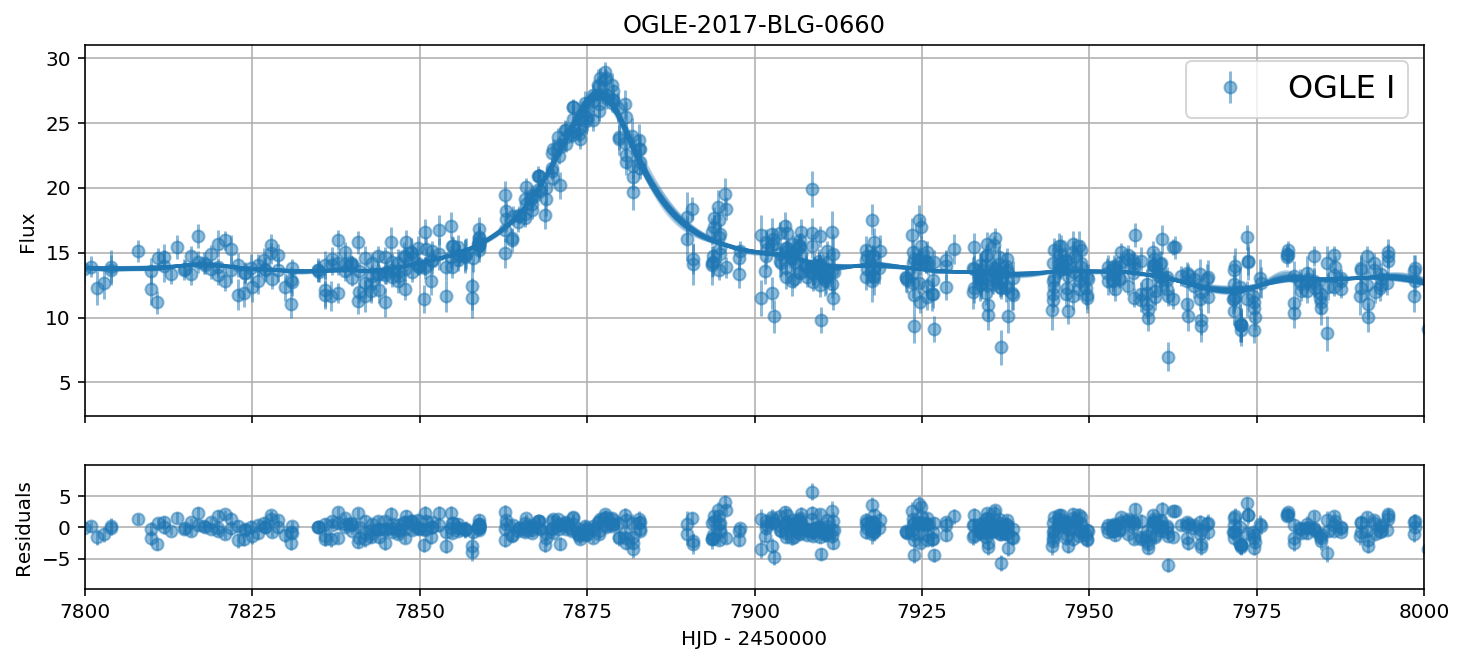

In [18]:
with model_gp:
    # Create dense grid
    t_dense = np.tile(np.linspace(7800, 8000, 1000), (n_bands, 1))
    t_dense_tensor = T.as_tensor_variable(t_dense)

    # Compute the trajectory of the lens
    trajectory = ca.trajectory.Trajectory(event, t0, u0, tE)
    u_dense = trajectory.compute_trajectory(t_dense_tensor)

    # Compute the magnification
    mag_dense = model_gp.compute_magnification(u_dense, u0)

    # Compute the mean model
    mean_dense = T.exp(ln_DeltaF) * mag_dense + T.exp(ln_Fbase)

# Plot model
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(12, 5), sharex=True
)

samples = list(xo.get_samples_from_trace(trace_gp, size=50))

with model_gp:
    ca.utils.plot_model_and_residuals(
        ax, event, samples, t_dense_tensor, mean_dense, gp_list=gp_list
    )

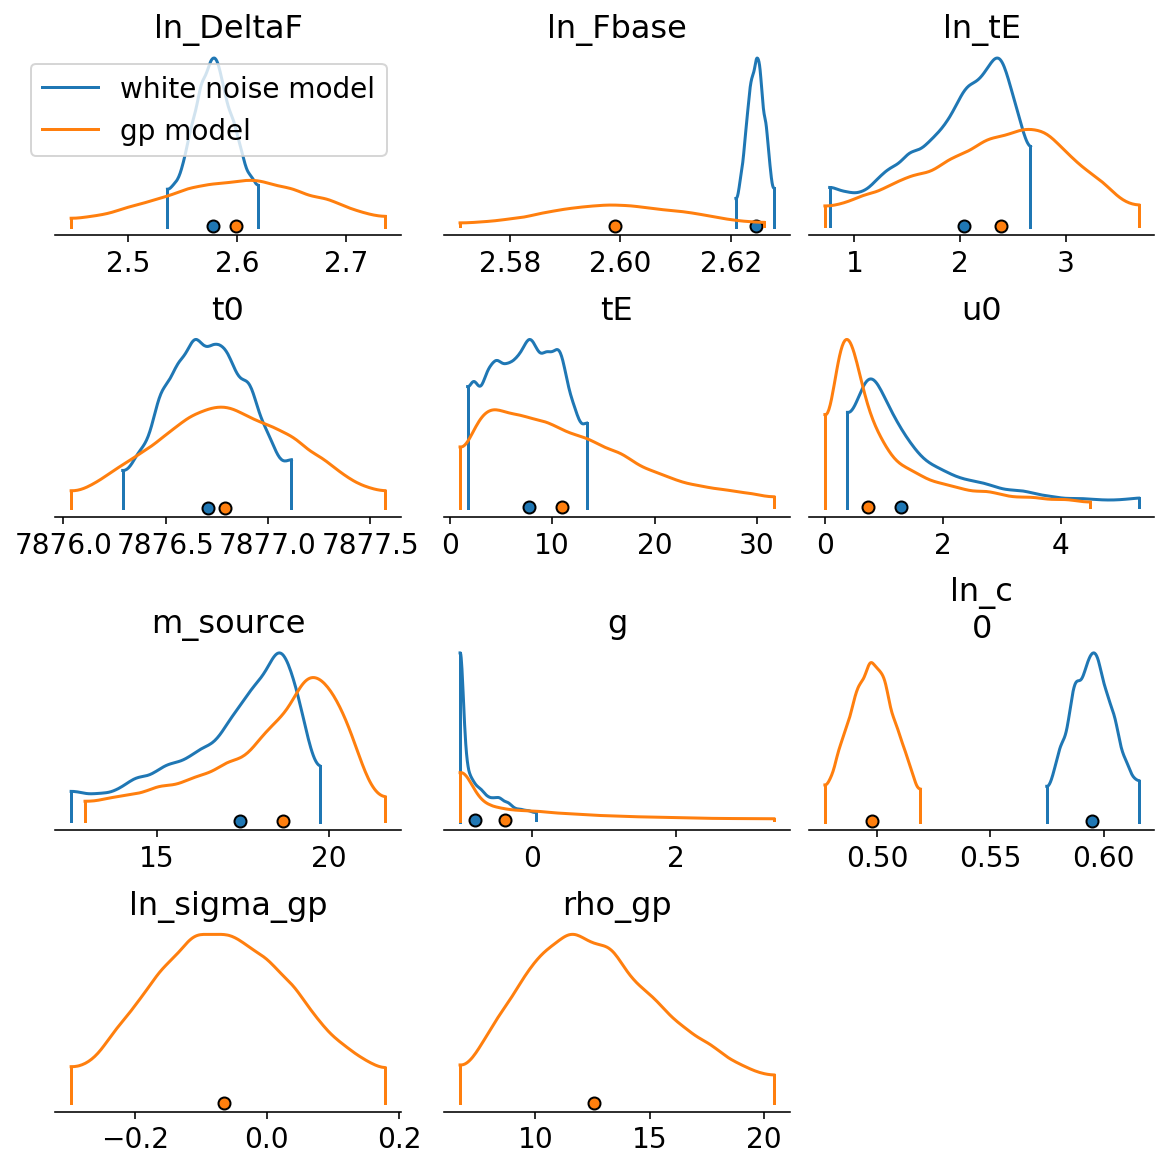

In [19]:
pm.plots.densityplot(
    [trace, trace_gp],
    point_estimate="median",
    figsize=(8, 8),
    data_labels=["white noise model", "gp model"],
);

In this case, the GP easily converged and there are no clear patterns in the residuals of the model. We also see substantial differences in the posteriors for the physical parameters, the point estimates are different and the variance of parameters is generally larger for the GP model.